In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy as cp
import importanceMatrix
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt

proj_path = os.path.dirname(os.getcwd())
fig_path = proj_path + '/2_docs/LaTeX/Figures'
datasets = []

In [27]:
def fit_RF(label, data, feature_names, class_col, class_names, class_tags, rnd_seed=45):
    X = np.array(data.loc[:,feature_names])
    y = np.array(data.loc[:,class_col])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rnd_seed)

    # train the classifier
    rf_clf = RandomForestClassifier(random_state=rnd_seed, n_estimators=100)
    rf_clf.fit(X_train, y_train)

    # make predictions and calculate the MAE error
    predictions = rf_clf.predict(X_test)
    errors = abs(predictions - y_test)
    print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

    # calculate the accuracy of the classifier
    acc = 100 * accuracy_score(y_test, predictions)
    print('Model Accuracy: {}'.format(round(acc, 2)))

    #print(np.unique(y, return_counts=True))
    #print(np.unique(y_train, return_counts=True))
    #print(np.unique(y_test, return_counts=True))
    return np.array([rf_clf, feature_names, y, y_test, predictions, class_names])

def f_top5(rf_clf, feature_names, y):
    global_importance = rf_clf.feature_importances_
    global_index = np.argsort(global_importance)
    global_index = global_index[::-1]
    
    imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
    mean_importance = np.mean(imp_mat, axis=0)
    pca_index = np.argsort(mean_importance)
    pca_index = pca_index[::-1]

    unique_classes, count_classes = np.unique(y, return_counts=True)
    is_balanced = all([i==j for i in count_classes for j in count_classes])
    rare_class_ind = np.argsort(count_classes)[0]
    rare_class = unique_classes[rare_class_ind]
    rare_class_index = np.argsort(imp_mat[rare_class_ind])
    rare_class_index = rare_class_index[::-1]
    
    ##FERMALI ALLA PRIMA ISTANZA DOVE DIFFERISCONO
    index = [i for i in np.arange(len(feature_names)) if global_index[i] != pca_index[i]]
    if len(index) == 0:
        print('FAIL')
        top5_global_features = feature_names[global_index[:3]]
        top5_pca_features = feature_names[pca_index[:3]]
        top5_rare_features = feature_names[rare_class_index[:3]]
        return [top5_global_features, top5_pca_features, top5_rare_features, rare_class_ind, is_balanced]
    elif index[0] > 2:
        top5_global_features = feature_names[global_index[:index[0]+1]]
        top5_pca_features = feature_names[pca_index[:index[0]+1]]
        top5_rare_features = feature_names[rare_class_index[:index[0]+1]]
        return [top5_global_features, top5_pca_features, top5_rare_features, rare_class_ind, is_balanced]
    else:
        print(index)
        top5_global_features = feature_names[global_index[:3]]
        top5_pca_features = feature_names[pca_index[:3]]
        top5_rare_features = feature_names[rare_class_index[:3]]
        return [top5_global_features, top5_pca_features, top5_rare_features, rare_class_ind, is_balanced]

def plot_confusion_matrix(y_true, y_pred, classes,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.plasma):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, label='Percentage')
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(round(cm[i, j],0), fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    return fig, ax

In [4]:
#Import dermatology data
col_names = np.array([
    'erythema', 'scaling', 'definite borders',
    'itching', 'koebner phenomenon', 'polygonal papules',
    'follicular papules', 'oral mucosal involvement', 'knee and elbow involvement',
    'scalp involvement', 'family history', 'melanin incontinence',
    'eosinophils in the infiltrate', 'PNL infiltrate', 'fibrosis of the papillary dermis',
    'exocytosis', 'acanthosis', 'hyperkeratosis',
    'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges',
    'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
    'focal hypergranulosis', 'disappearance of the granular layer',
    'vacuolisation and damage of basal layer',
    'spongiosis', 'saw-tooth appearance of retes', 'follicular horn plug',
    'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate',
    'band-like infiltrate',
    'Age', 'Class'
])
col_names = np.array([lab.capitalize() for lab in col_names])
feature_names = np.array(col_names[:-1])
class_col = col_names[-1]
class_names = np.array(['psoriasis', 'seboreic dermatitis', 'lichen planus',
                        'pityriasis rosea', 'cronic dermatitis', 'pityriasis rubra pilaris'])
class_names = np.array([lab.capitalize() for lab in class_names])
class_tags = np.arange(len(class_names)) + 1
data = pd.read_csv(proj_path+'/0_data/dermatology.data.csv', header=None, names=col_names)
skip_rows = data.Age == '?'
data = data[~skip_rows]
data.Age = np.array(data.Age, dtype=int)

rnd_seed = 45
datasets.append(['Dermatology', data, feature_names, class_col, class_names, class_tags, rnd_seed])
    
#fit_RF(*datasets[-1])

In [5]:
#Import wine and iris
from sklearn.datasets import load_iris, load_wine

iris = load_iris()
feature_names = np.array(iris.feature_names)
class_names = iris.target_names
class_tags = np.array([0, 1, 2])
class_col = 'Class'

iris_data = pd.DataFrame(iris.data,columns=feature_names)
iris_data[class_col] = pd.Series(iris.target)

rnd_seed = 45
datasets.append(['Iris', iris_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

wines = load_wine()
feature_names = np.array(wines.feature_names)
class_names = wines.target_names
class_tags = np.array([0, 1, 2])
class_col = 'Class'

wine_data = pd.DataFrame(wines.data,columns=feature_names)
wine_data[class_col] = pd.Series(wines.target)

rnd_seed = 45
datasets.append(['Wine', wine_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

In [6]:
#Breast tissue data

breast_data = pd.read_excel(proj_path+'/0_data/BreastTissue.xls', sheet_name=1)
breast_data = breast_data.iloc[:,1:]

feature_names = np.array(breast_data.columns[1:])
class_col = 'Class'
class_names = np.unique(breast_data.Class)
class_tags = np.arange(len(class_names))

string_to_int = dict(zip(class_names, class_tags))
breast_data.loc[:,'Class'] = breast_data.apply(lambda r: string_to_int[r.Class], axis=1)

rnd_seed = 45
datasets.append(['Breast_tissue', breast_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

In [7]:
#Students data
col_names = np.array([
    'Gender', 'Caste', 'Class X Percentage', 'Class XII Percentage', 'Internal Assessment Percentage',
    'End Semester Percentage', 'Whether the student has back or arrear papers', 'Marital Status',
    'Lived in Town or Village', 'Admission Category', 'Family Monthly Income', 'Family Size',
    'Father Qualification', 'Mother Qualification', 'Father Occupation', 'Mother Occupation',
    'Number of Friends', 'Study Hours', 'Student School attended at Class X level', 'Medium',
    'Home to College Travel Time', 'Class Attendance Percentage'
])
col_names = np.array([lab.capitalize() for lab in col_names])
students_data = pd.read_csv(proj_path+'/0_data/Student_performances.csv', header=None, names=col_names)
students_data = students_data.loc[:,col_names!='Marital status']

string_to_int_list = [
    {'M':0,'F':1}, {'G':0,'ST':1,'SC':2,'OBC':3,'MOBC':4}, {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0},
    {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0}, {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0},
    {'Best':4,'Vg':3,'Good':2,'Pass':1,'Fail':0}, {'Y':1,'N':0},
    {'T':1,'V':0}, {'Free':0,'Paid':1},
    {'Vh':4,'High':3,'Am':2,'Medium':1,'Low':0}, {'Large':2,'Average':1,'Small':0},
    {'Il':0,'Um':1,'10':2,'12':3,'Degree':4,'Pg':5}, {'Il':0,'Um':1,'10':2,'12':3,'Degree':4,'Pg':5},
    {'Service':0,'Business':1,'Retired':2,'Farmer':3,'Others':4},
    {'Service':0,'Business':1,'Retired':2,'Housewife':3,'Others':4},
    {'Large':2,'Average':1,'Small':0}, {'Good':2,'Average':1,'Poor':0},
    {'Govt':1,'Private':0}, {'Eng':0,'Asm':1,'Hin':2,'Ben':3},
    {'Large':2,'Average':1,'Small':0}, {'Good':2,'Average':1,'Poor':0}
]
for col_name,string_to_int in zip(students_data.columns, string_to_int_list):
    #print(col_name,string_to_int,
    #     students_data.apply(lambda r: string_to_int[r[col_name]], axis=1))
    students_data.loc[:,col_name] = students_data.apply(lambda r: string_to_int[r[col_name]], axis=1)
    
feature_names = np.array(students_data.columns[students_data.columns!='End semester percentage'])
class_col = 'End semester percentage'
class_names = np.array(['Fail', 'Pass', 'Good', 'Vg', 'Best'])
class_tags = np.arange(len(class_names))
print(feature_names, class_names, class_tags)

rnd_seed = 44
datasets.append(['Student_finals', students_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

['Gender' 'Caste' 'Class x percentage' 'Class xii percentage'
 'Internal assessment percentage'
 'Whether the student has back or arrear papers'
 'Lived in town or village' 'Admission category' 'Family monthly income'
 'Family size' 'Father qualification' 'Mother qualification'
 'Father occupation' 'Mother occupation' 'Number of friends' 'Study hours'
 'Student school attended at class x level' 'Medium'
 'Home to college travel time' 'Class attendance percentage'] ['Fail' 'Pass' 'Good' 'Vg' 'Best'] [0 1 2 3 4]


In [8]:
#Cars data

mtcars_data = pd.read_csv(proj_path+'/0_data/mtcars.csv')
mtcars_data = mtcars_data.iloc[:,1:]

class_names = np.unique(mtcars_data.gear)
feature_names = np.array(mtcars_data.columns[mtcars_data.columns!='gear'])
class_col = 'gear'
class_tags = class_names

rnd_seed = 45
datasets.append(['Mtcars', mtcars_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

In [9]:
#Wholesale customers data

sales_data = pd.read_csv(proj_path+'/0_data/Wholesale customers data.csv')

class_names = np.unique(sales_data.Region)
feature_names = np.array(sales_data.columns[sales_data.columns!='Region'])
class_col = 'Region'
class_tags = class_names
#print(np.unique(sales_data.Region, return_counts=True))
sales_data

rnd_seed = 44
datasets.append(['Sales', sales_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

In [10]:
#WiFi signals data
wifi_data = pd.read_excel(proj_path+'/0_data/WiFi_signals.xls')

class_names = np.unique(wifi_data.Room)
feature_names = np.array(wifi_data.columns[wifi_data.columns!='Room'])
class_col = 'Room'
class_tags = class_names
#print(class_names, feature_names, np.unique(wifi_data.Room, return_counts=True))

rnd_seed = 45
datasets.append(['Wifi', wifi_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

In [11]:
#Import flag data
col_names = np.array([
    'name', 'landmass', 'zone', 'area', 'population', 'language', 'religion', 'bars', 'stripes', 'colours',
    'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses', 'saltires',
    'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'topleft', 'botright'
])
col_names = np.array([lab.capitalize() for lab in col_names])
feature_names = np.array(col_names[np.logical_and(col_names!='Religion', col_names!='Name')])
class_col = 'Religion'
class_names = np.array(['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Others'])
class_tags = np.arange(len(class_names))
flag_data = pd.read_csv(proj_path+'/0_data/flag.data.csv', header=None, names=col_names)

#print(class_names, feature_names, np.unique(flag_data.Religion, return_counts=True))

string_to_int = {'black':0, 'blue':1, 'brown':2, 'gold':3, 'green':4, 'orange':5, 'red':6, 'white':7}
for col_name in ['Mainhue', 'Topleft', 'Botright']:
    #print(col_name,string_to_int)
    flag_data.loc[:,col_name] = flag_data.apply(lambda r: string_to_int[r[col_name]], axis=1)

#print(flag_data.head())
#print(np.unique(np.hstack([flag_data.Mainhue, flag_data.Topleft, flag_data.Botright])))
rnd_seed = 37
datasets.append(['Flag', flag_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

In [12]:
#Import tumor data
col_names = np.array([
    'class', 'age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura',
    'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal'
])
col_names = np.array([lab.capitalize() for lab in col_names])
feature_names = col_names[col_names!='Class']
class_names = np.array([
    'lung', 'head & neck', 'esophasus', 'thyroid', 'stomach', 'duoden & sm.int',
    'colon', 'rectum', 'anus', 'salivary glands', 'pancreas', 'gallblader',
    'liver', 'kidney', 'bladder', 'testis', 'prostate', 'ovary', 'corpus uteri', 
    'cervix uteri', 'vagina', 'breast'
])
#class_tags = np.arange(len(class_names))
tumor_data = pd.read_csv(proj_path+'/0_data/primary-tumor.data.csv', header=None, names=col_names)
tumor_data = tumor_data.loc[:,[col for col in col_names if not(col in ['Histologic-type', 'Degree-of-diffe'])]]
tumor_data.apply(lambda r: any(r=='?'),axis=1)
tumor_data = tumor_data.loc[~(tumor_data.apply(lambda r: any(r=='?'),axis=1)),:]
low_data_classes = np.array([6, 9, 10, 15, 16, 20, 21])

print('remove classes', class_names[low_data_classes-1])
tumor_data = tumor_data.loc[~tumor_data.Class.isin(low_data_classes)]

col_names = tumor_data.columns
feature_names = np.array(col_names[col_names!='Class'])
class_names = np.array([col for col in class_names if not(col in class_names[low_data_classes-1])])
class_tags = np.unique(tumor_data.Class)
class_col = 'Class'
#print(class_names, feature_names, np.unique(tumor_data.Class, return_counts=True))

rnd_seed = 45
datasets.append(['Tumor', tumor_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

remove classes ['duoden & sm.int' 'anus' 'salivary glands' 'bladder' 'testis'
 'cervix uteri' 'vagina']


In [13]:
#Car data

col_names = np.array([
    'buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'
])
col_names = np.array([lab.capitalize() for lab in col_names])
car_data = pd.read_csv(proj_path+'/0_data/car.data.csv', header=None, names=col_names)

string_to_int_list = [
    {'vhigh':3, 'high':2, 'med':1, 'low':0},
    {'vhigh':3, 'high':2, 'med':1, 'low':0},
    {'2':2, '3':3, '4':4, '5more':5},
    {'2':0, '4':1, 'more':2},
    {'small':0, 'med':1, 'big':2},
    {'low':0, 'med':1, 'high':2},
    {'unacc':0, 'acc':1, 'good':2, 'vgood':3}
]

for col_name,string_to_int in zip(car_data.columns, string_to_int_list):
    car_data.loc[:,col_name] = car_data.apply(lambda r: string_to_int[r[col_name]], axis=1)

    
feature_names = np.array(car_data.columns[car_data.columns!='Class'])
class_col = 'Class'
class_names = np.array(['unacc', 'acc', 'good', 'vgood'])
class_tags = np.arange(len(class_names))
print(feature_names, class_names, class_tags)

rnd_seed = 45
datasets.append(['Cars', car_data, feature_names, class_col, class_names, class_tags, rnd_seed])
#fit_RF(*datasets[-1])

['Buying' 'Maint' 'Doors' 'Persons' 'Lug_boot' 'Safety'] ['unacc' 'acc' 'good' 'vgood'] [0 1 2 3]


In [28]:
RF_fits = [fit_RF(*data) for data in datasets]

Mean Absolute Error: 0.02
Model Accuracy: 98.89
Mean Absolute Error: 0.05
Model Accuracy: 94.74
Mean Absolute Error: 0.0
Model Accuracy: 100.0
Mean Absolute Error: 0.41
Model Accuracy: 74.07
Mean Absolute Error: 0.33
Model Accuracy: 69.7
Mean Absolute Error: 0.25
Model Accuracy: 75.0
Mean Absolute Error: 0.46
Model Accuracy: 72.73
Mean Absolute Error: 0.04
Model Accuracy: 98.2
Mean Absolute Error: 0.65
Model Accuracy: 71.43
Mean Absolute Error: 4.59
Model Accuracy: 39.02
Mean Absolute Error: 0.03
Model Accuracy: 98.15


In [29]:
top5_features = [f_top5(*(fits_y[:3])) for fits_y in RF_fits]

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 28, 29]
FAIL
[0, 1]
[2, 3]
FAIL
FAIL
FAIL


Dermatology False False Pityriasis rubra pilaris False
Mean Absolute Error: 0.54
Model Accuracy: 63.33


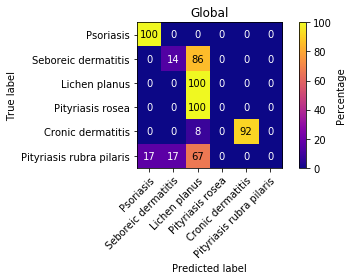

Mean Absolute Error: 0.47
Model Accuracy: 76.67


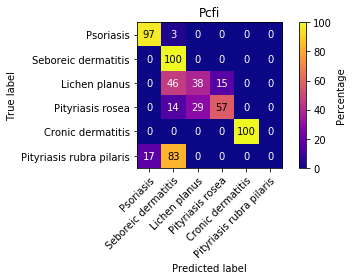

Pityriasis rubra pilaris
Mean Absolute Error: 1.36
Model Accuracy: 43.33


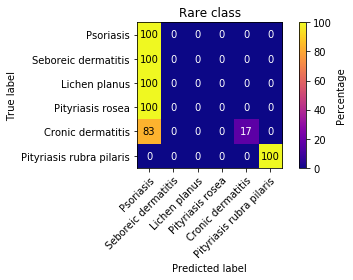

Iris True True setosa True
Mean Absolute Error: 0.05
Model Accuracy: 94.74


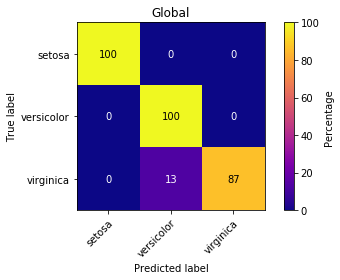

Mean Absolute Error: 0.05
Model Accuracy: 94.74


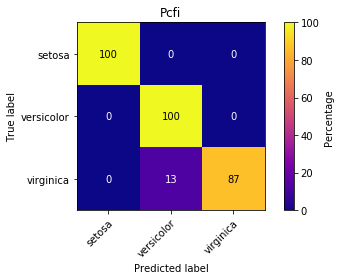

setosa
Mean Absolute Error: 0.05
Model Accuracy: 94.74


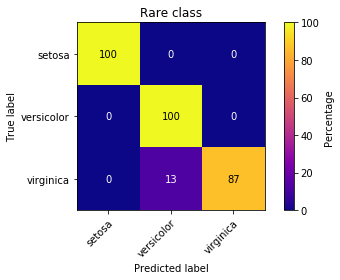

Wine False False class_2 False
Mean Absolute Error: 0.0
Model Accuracy: 100.0


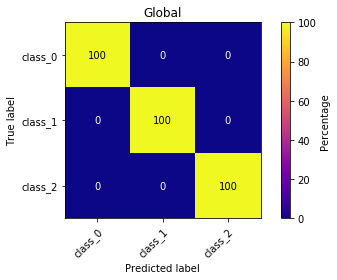

Mean Absolute Error: 0.0
Model Accuracy: 100.0


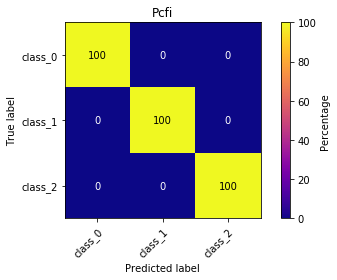

class_2
Mean Absolute Error: 0.04
Model Accuracy: 95.56


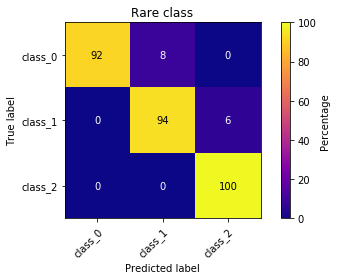

Breast_tissue True False con False
Mean Absolute Error: 0.44
Model Accuracy: 66.67


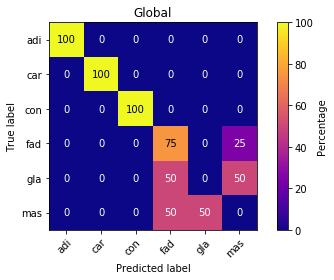

Mean Absolute Error: 0.56
Model Accuracy: 62.96


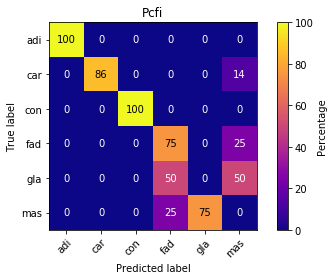

con
Mean Absolute Error: 0.56
Model Accuracy: 74.07


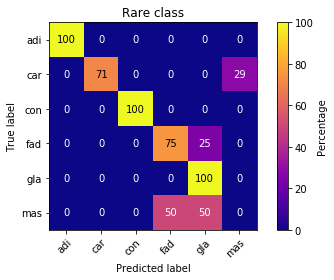

Student_finals False True Vg False
Mean Absolute Error: 0.48
Model Accuracy: 54.55


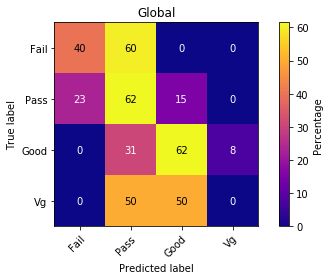

Mean Absolute Error: 0.36
Model Accuracy: 66.67


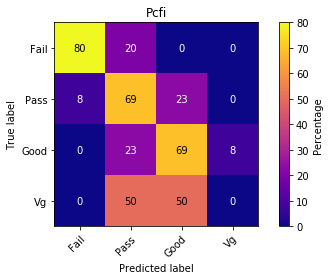

Vg
Mean Absolute Error: 0.36
Model Accuracy: 66.67


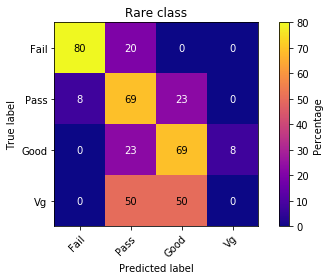

Mtcars False False 5 False
Mean Absolute Error: 0.25
Model Accuracy: 75.0


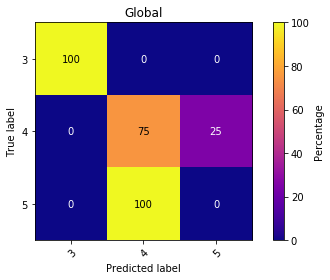

Mean Absolute Error: 0.25
Model Accuracy: 75.0


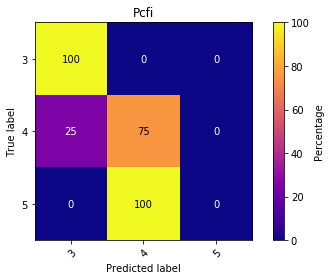

5
Mean Absolute Error: 0.25
Model Accuracy: 87.5


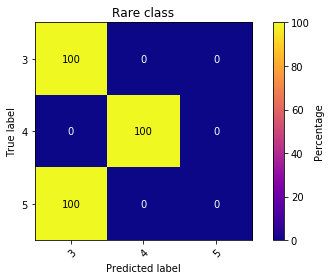

Sales True False 2 False
Mean Absolute Error: 0.57
Model Accuracy: 65.45


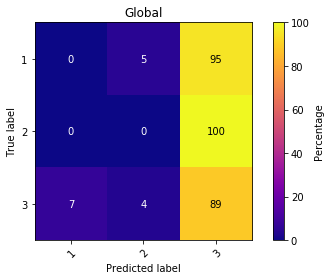

Mean Absolute Error: 0.57
Model Accuracy: 65.45


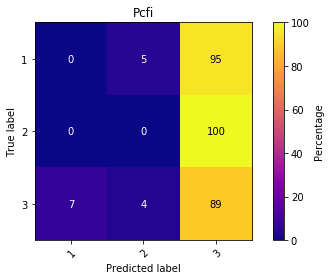

2
Mean Absolute Error: 0.53
Model Accuracy: 69.09


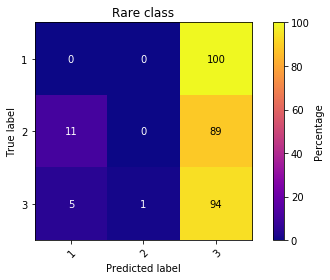

Wifi True True 1 True
Mean Absolute Error: 0.04
Model Accuracy: 97.8


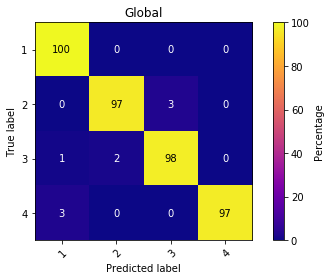

Mean Absolute Error: 0.04
Model Accuracy: 97.8


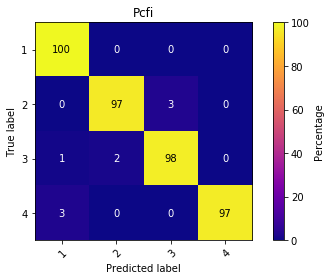

1
Mean Absolute Error: 0.04
Model Accuracy: 97.8


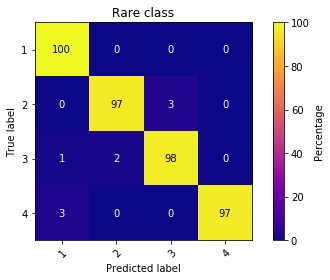

Flag False False Hindu False
Mean Absolute Error: 0.86
Model Accuracy: 69.39


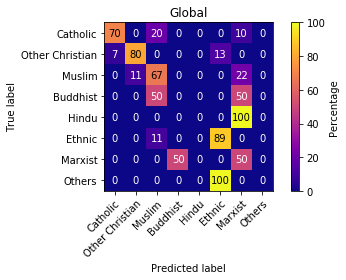

Mean Absolute Error: 0.88
Model Accuracy: 67.35


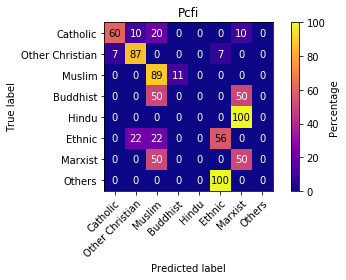

Hindu
Mean Absolute Error: 1.35
Model Accuracy: 51.02


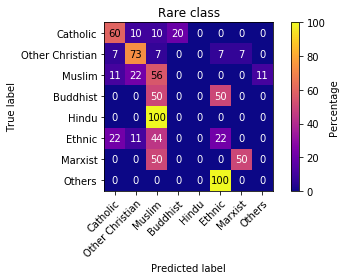

Tumor False False rectum False
Mean Absolute Error: 4.8
Model Accuracy: 34.15


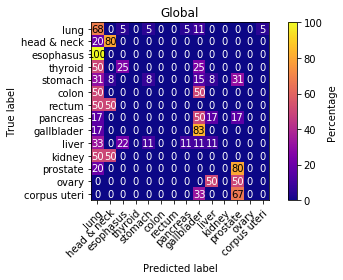

Mean Absolute Error: 6.15
Model Accuracy: 30.49


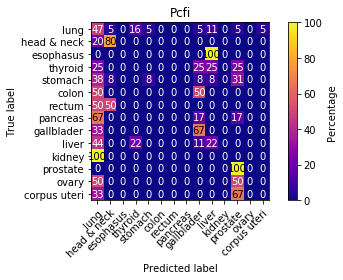

rectum
Mean Absolute Error: 7.04
Model Accuracy: 17.07


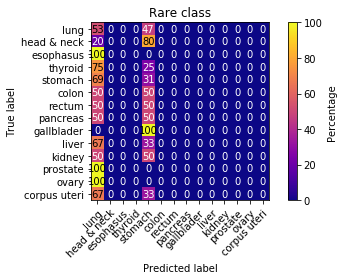

Cars True False vgood False
Mean Absolute Error: 0.27
Model Accuracy: 76.62


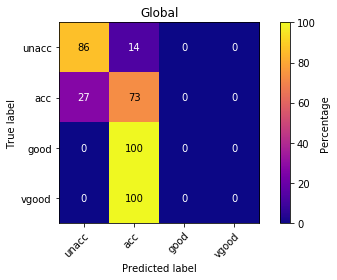

Mean Absolute Error: 0.27
Model Accuracy: 76.62


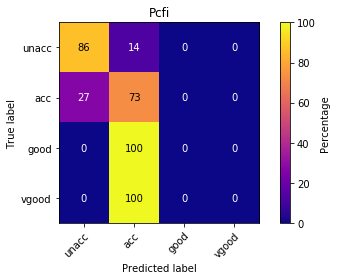

vgood
Mean Absolute Error: 0.4
Model Accuracy: 67.82


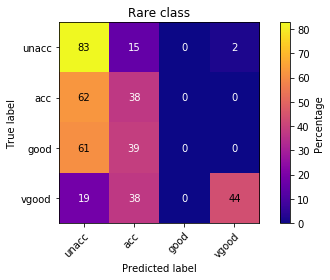

In [30]:
#CHECK THEY ARE DIFFERENT
for k in range(len(datasets)):
    data = cp.deepcopy(datasets[k])
    label = data[0]
    f1, f2, f3, rare_class_ind, is_balanced = top5_features[k]
    print(label, all(lab in f1 for lab in f2), all(lab in f3 for lab in f2),
          RF_fits[k][-1][rare_class_ind], is_balanced)
    #print(f1)
    #print(f2)
    #print(f3)
    
    data[2] = f1
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Global')
    #fig.savefig(fig_path+'/confusion_matrix_default_method.pdf', bbox_inches='tight')
    plt.show()
    
    data[2] = f2
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Pcfi')
    #fig.savefig(fig_path+'/confusion_matrix_pcfi_method.pdf', bbox_inches='tight')
    plt.show()
    
    print(RF_fits[k][-1][rare_class_ind])
    data[2] = f3
    fit_param = fit_RF(*data)
    fig, ax = plot_confusion_matrix(*(fit_param[-3:]),# y_test, predictions, class_names,
                      title='Rare class')
    #fig.savefig(fig_path+'/confusion_matrix_rare_class_method.pdf', bbox_inches='tight')
    plt.show()

In [37]:
"""
Iris uguale
Breast Tissue ordine diverso
Sales uguale
Wifi uguale
Cars uguale
"""

'\nIris uguale\nBreast Tissue ordine diverso\nSales uguale\nWifi uguale\nCars uguale\n'

In [ ]:
X = np.array(data.loc[:,col_names[:-1]])
y = np.array(data.loc[:,col_names[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)

# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 

# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

In [ ]:
###Class count plot
fig, ax = plt.subplots(figsize=(3.24*1.5, 2*1.5))
sns.countplot(y, color=sns.color_palette()[0], ax=ax, orient='h')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticklabels(np.unique(y), rotation=45, ha='right', rotation_mode='anchor')
sns.despine(fig=fig)
#fig.savefig(fig_path+'/class_counts.pdf', bbox_inches='tight')

In [ ]:
global_importance = rf_clf.feature_importances_
global_index = np.argsort(global_importance)

imp_mat = importanceMatrix.calcImportanceMatrix(rf_clf)
mean_importance = np.mean(imp_mat, axis=0)
pca_index = np.argsort(mean_importance)

unique_classes, count_classes = np.unique(y, return_counts=True)
rare_class_ind = np.argsort(count_classes)[0]
rare_class = unique_classes[rare_class_ind]
rare_class_index = np.argsort(imp_mat[rare_class_ind])

top5_global_features = feature_names[global_index[-5:]]
top5_pca_features = feature_names[pca_index[-5:]]
top5_rare_features = feature_names[rare_class_index[-5:]]
print(top5_global_features)
print(top5_pca_features)
print(top5_rare_features)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.plasma):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, label='Percentage')
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(round(cm[i, j],0), fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    return fig, ax

In [ ]:
feat_ind = np.array([feat in top5_global_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

fig, ax = plot_confusion_matrix(y_test, predictions, class_names,
                      title='Default method')
fig.savefig(fig_path+'/confusion_matrix_default_method.pdf', bbox_inches='tight')
plt.show()

In [ ]:
feat_ind = np.array([feat in top5_pca_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

fig, ax = plot_confusion_matrix(y_test, predictions, class_names,
                      title='Per-class average method')
fig.savefig(fig_path+'/confusion_matrix_perclass_average.pdf', bbox_inches='tight')
plt.show()

In [ ]:
feat_ind = np.array([feat in top5_rare_features for feat in feature_names])
X_train, X_test, y_train, y_test = train_test_split(X[:,feat_ind], y, random_state=45)
# train the classifier
rf_clf = RandomForestClassifier(random_state=45, n_estimators=100)
rf_clf.fit(X_train, y_train)
# make predictions and calculate the MAE error
predictions = rf_clf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) 
# calculate the accuracy of the classifier
acc = 100 * accuracy_score(y_test, predictions)
print('Model Accuracy: {}'.format(round(acc, 2)))

fig, ax = plot_confusion_matrix(y_test, predictions, class_names,
                      title='Rare class method')
fig.savefig(fig_path+'/confusion_matrix_rare_class.pdf', bbox_inches='tight')
plt.show()